In [ ]:
import pandas as pd
import requests
import seaborn as sns

sns.set_theme(palette="deep")


In [ ]:
from io import BytesIO
from urllib.parse import urlencode

base_url = "anonymized"
public_key = "anonymized"

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()["href"]
response = requests.get(download_url)

path_to_dataset = "data"  # Choose any appropriate local path


parquet_file = BytesIO(response.content)
df = pd.read_parquet(parquet_file, engine="pyarrow")  # or engine='fastparquet'

# zipfile = ZipFile(BytesIO(response.content))
# zipfile.extractall(path=path_to_dataset)

In [3]:
mmlu_entropy_df = df
mmlu_entropy_df.head()

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,phi3_ans_correct,phi3_entropies,phi3_every_token_info,phi3_ans_token_index,phi3_response,phi3_input_embeddings,phi3_think_embeddings,phi3_answer_embeddings
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,True,"[0.8887168169021606, 1.6030447483062744, 0.143...","[[{""token_idx"": 12, ""token_prob"": 1.2961473657...",361,"To answer this question, let's first understan...","{""min"": [-1.7109375, -1.4453125, -0.97265625, ...","{""min"": [-1.7421875, -1.609375, -0.7421875, -1...","{""min"": [0.1708984375, -0.94921875, 0.34960937..."
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,True,"[0.5754676461219788, 0.5695227384567261, 0.025...","[[{""token_idx"": 1, ""token_prob"": 1.48891549542...",319,To determine which of the given articles are n...,"{""min"": [-1.359375, -1.765625, -0.55859375, -1...","{""min"": [-2.0625, -1.6953125, -0.7421875, -1.3...","{""min"": [0.1123046875, -0.921875, 0.5234375, 1..."
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[1.203656554222107, 1.445164442062378, 0.14232...","[[{""token_idx"": 1, ""token_prob"": 1.53181808855...",347,"To answer this question, let's analyze each op...","{""min"": [-1.5625, -1.828125, -0.53515625, -1.1...","{""min"": [-1.953125, -1.578125, -0.349609375, -...","{""min"": [0.130859375, -0.953125, 0.306640625, ..."
3,stemez-Business,J,"['$308.25', '$142.75', '$199.99', '$225.85', '...",business,Margaret Denault recently rented a truck to dr...,NaN,94,9,118,Economics & Finance MCQs,Business Finance Questions,False,"[0.6496801376342773, 1.174181342124939, 0.0581...","[[{""token_idx"": 16, ""token_prob"": 0.0012652330...",316,"To find the total cost of the rental, we need ...","{""min"": [-1.59375, -1.6015625, -0.36328125, -0...","{""min"": [-2.140625, -2.234375, -0.9921875, -2....","{""min"": [0.08251953125, -0.859375, 0.36328125,..."
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,True,"[0.9100953340530396, 1.2733248472213745, 0.026...","[[{""token_idx"": 16, ""token_prob"": 0.0039558755...",154,To find the expected market value of the prope...,"{""min"": [-1.5, -1.4453125, -0.578125, -0.85156...","{""min"": [-2.0625, -2.125, -0.8203125, -1.125, ...","{""min"": [0.06640625, -1.015625, 0.44140625, 1...."


In [6]:
mmlu_entropy_df.value_counts("phi3_ans_token_index", dropna=False)

phi3_ans_token_index
-1      1336
 315      45
 319      40
 363      40
 365      40
        ... 
 835       1
 79        1
 837       1
 838       1
 87        1
Length: 863, dtype: int64

In [7]:
# Filter out unanswered questions (phi3_ans_token_index == -1)

mmlu_entropy_df_filtered = mmlu_entropy_df[mmlu_entropy_df["phi3_ans_token_index"] != -1]

print(f"Len = {len(mmlu_entropy_df)} before filtering and {len(mmlu_entropy_df_filtered)} after filtering")

Len = 12032 before filtering and 10696 after filtering


In [ ]:
def entropy_counter(arr):
    sum = 0
    for i in arr:
        sum -= i["token_prob"] * np.log(i["token_prob"])
    return sum

In [ ]:
import json

import matplotlib.pyplot as plt
import numpy as np


def extract_cot_answer_from_row(tokenizer, row, column_every_token_info, column_ans_token_index):
    every_token_info = json.loads(row[column_every_token_info])
    answer_token_probs = every_token_info[row[column_ans_token_index]]

    max_prob_idx = np.argmax([item["token_prob"] for item in answer_token_probs])
    answer_token = answer_token_probs[max_prob_idx]["token_idx"]
    return tokenizer.decode(answer_token)


def extract_cot_answer_entropy_from_row(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    return answer_token_entropy


def visualize_entropy_all(df, x, hue, model_name=None):
    plt.figure(figsize=(14, 6))
    ax = sns.histplot(
        df,
        x=x,
        bins=30,
        hue=hue,
        hue_order=[False, True],
        multiple="dodge",
    )
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Count")
    plt.legend(
        handles=ax.get_legend().legend_handles, labels=["Incorrect", "Correct"], title="Answer", loc="upper right"
    )
    if model_name is not None:
        plt.title(model_name)
    # plt.savefig("entropy_phi3.pdf")

    plt.figure(figsize=(14, 6))
    ax = sns.histplot(
        df,
        x=x,
        bins=30,
        hue=hue,
        hue_order=[False, True],
        multiple="fill",
    )
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Proportion")
    plt.legend(handles=ax.get_legend().legend_handles, labels=["Incorrect", "Correct"], title="Answer")
    if model_name is not None:
        plt.title(model_name)


In [10]:
import ast

len(ast.literal_eval(mmlu_entropy_df_filtered.phi3_entropies.iloc[0]))

364

In [11]:
from transformers import AutoTokenizer

# from reasoning_fine_tune.utils.processing import extract_cot_answer_entropy_from_row, extract_cot_answer_from_row

MODEL_NAME = "microsoft/Phi-4-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

mmlu_entropy_df_filtered["phi3_answer"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_from_row(tokenizer, row, "phi3_every_token_info", "phi3_ans_token_index"), axis=1
)
mmlu_entropy_df_filtered["phi3_answer_entropy"] = mmlu_entropy_df_filtered.apply(
    lambda row: extract_cot_answer_entropy_from_row(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-05-19 09:50:53.658482: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 09:50:55.236975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-19 09:51:00.320634: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_10190/144845555

In [ ]:
[
    tokenizer.encode(".\n\n"),
    tokenizer.encode(".\n"),
    tokenizer.encode("\n"),
    tokenizer.encode("\n\n"),
    tokenizer.encode(":\n\n"),
    tokenizer.encode(":\n"),
    tokenizer.encode("]\n"),
    tokenizer.encode("]\n\n"),
    tokenizer.encode(";\n\n"),
    tokenizer.encode(";\n"),
    tokenizer.encode(";"),
    tokenizer.encode("..."),
    tokenizer.encode("**\n\n"),
    tokenizer.encode("**\n"),
    tokenizer.encode("*\n\n"),
    tokenizer.encode("*\n"),
]

[[364],
 [558],
 [198],
 [279],
 [1402],
 [734],
 [1592],
 [3144],
 [502],
 [307],
 [26],
 [1008],
 [91587],
 [1612],
 [26289],
 [6658]]

In [16]:
ast.literal_eval(mmlu_entropy_df_filtered.phi3_every_token_info.iloc[0])[-1]

[{'token_idx': 8, 'token_prob': 1.0124479558726307e-05},
 {'token_idx': 220, 'token_prob': 3.5337907320354134e-05},
 {'token_idx': 256, 'token_prob': 1.4731031114934012e-05},
 {'token_idx': 410, 'token_prob': 1.0124479558726307e-05},
 {'token_idx': 723, 'token_prob': 1.4731031114934012e-05},
 {'token_idx': 9237, 'token_prob': 4.004309084848501e-05},
 {'token_idx': 199999, 'token_prob': 2.42873647948727e-05},
 {'token_idx': 200020, 'token_prob': 0.9994458556175232}]

In [17]:
tokenizer.decode(200020)

'<|end|>'

In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        maxi = 0
        maxii = 0
        for i in sublist:
            if i["token_prob"] > maxi:
                maxii = maxi
                maxi = i["token_prob"]
        prob_max.append(1 - (maxi - maxii))
    return np.mean(prob_max)
    # return


mmlu_entropy_df_filtered["phi3_prob_diff_ent"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)

/tmp/ipykernel_10190/3222809347.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_prob_diff_ent"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        prob_max.append(np.max([item["token_prob"] for item in sublist]))

    # return answer_token_entropy
    return prob_max


mmlu_entropy_df_filtered["phi3_max_prob"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)


def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]
    ev = json.loads(row[every])
    prob_max = []
    for sublist in ev:
        prob_max.append(sublist[np.argmax([item["token_prob"] for item in sublist])]["token_idx"])

    # return answer_token_entropy
    return prob_max


mmlu_entropy_df_filtered["phi3_argmax_prob"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)

/tmp/ipykernel_10190/198420212.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_max_prob"] = mmlu_entropy_df_filtered.apply(
/tmp/ipykernel_10190/198420212.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_argmax_prob"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    return np.mean([ind for ind in entropies])


mmlu_entropy_df_filtered["phi3_answer_entropy_cot_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/tmp/ipykernel_10190/785479905.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_cot_mean"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index, every):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    return np.max([ind for ind in entropies])


mmlu_entropy_df_filtered["phi3_answer_entropy_cot_max"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index", "phi3_every_token_info"), axis=1
)

/tmp/ipykernel_10190/459748147.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_cot_max"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    # return answer_token_entropy
    # return np.mean([ind for ind in entropies])
    return np.abs(np.max([ind for ind in entropies]) - answer_token_entropy)


mmlu_entropy_df_filtered["phi3_answer_entropy_marg"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/tmp/ipykernel_10190/3928390433.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_marg"] = mmlu_entropy_df_filtered.apply(


In [ ]:
def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    # ev = json.loads(row[every])
    # print()
    answer_token_entropy = entropies[row[column_ans_token_index]]

    top1, top2 = sorted(entropies, reverse=True)[:2]

    return abs(top1 - top2)
    # why = np.argmax([ind['token_prob'] for ind in ast.literal_eval(row[every])[check]])

    # piv = ast.literal_eval(mmlu_entropy_df_filtered.phi3_every_token_info.iloc[ran])[check][why]['token_idx']


mmlu_entropy_df_filtered["phi3_answer_entropy_top_diff"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

/tmp/ipykernel_10190/2287951263.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mmlu_entropy_df_filtered["phi3_answer_entropy_top_diff"] = mmlu_entropy_df_filtered.apply(


In [24]:
from dataclasses import dataclass

import pandas as pd
from sklearn.metrics import roc_auc_score


def normalize_score(column):
    return 1 - column / column.max()


@dataclass
class ROC_AUC:
    roc_auc: float
    gini: float


def calculate_roc_auc(y_true, y_score):
    roc_auc = roc_auc_score(y_true, y_score)
    gini = abs(2 * roc_auc - 1)
    return ROC_AUC(roc_auc=roc_auc, gini=gini)


def calculate_accuracy(df, model_answer_correct_col):
    return df[model_answer_correct_col].sum() / len(df)


def calculate_roc_auc_by_category(df, model_name, category_col, model_answer_correct_col, score_col, threshold=10):
    results = []

    roc_auc = calculate_roc_auc(df[model_answer_correct_col], normalize_score(df[score_col]))

    results.append(
        {
            "category": "ALL",
            "roc_auc": roc_auc.roc_auc,
            "gini": roc_auc.gini,
            "num_samples": len(df),
            "accuracy": calculate_accuracy(df, model_answer_correct_col),
            "model": model_name,
            "metric": score_col,
        }
    )

    for category in df[category_col].unique():
        df_cat = df[df[category_col] == category]
        if len(df_cat) < threshold:
            continue

        roc_auc = calculate_roc_auc(df_cat[model_answer_correct_col], normalize_score(df_cat[score_col]))

        results.append(
            {
                "category": category,
                "roc_auc": roc_auc.roc_auc,
                "gini": roc_auc.gini,
                "num_samples": len(df_cat),
                "accuracy": calculate_accuracy(df_cat, model_answer_correct_col),
                "model": model_name,
                "metric": score_col,
            }
        )

    return pd.DataFrame(results)

In [ ]:
option_ids = [str(i + 1) for i in range(20)]
# 0 is a special exception for "do not know"
option_ids_w_fallback = option_ids + ["0"]


def validate_mmlu_answer(answer):
    return str(answer) in option_ids_w_fallback


def keep_only_valid_and_known_answers(df, column_name, option_ids=option_ids):
    return df[df[column_name].isin(option_ids)]

In [26]:
# Filter out incorrectly formatted answers (answer token is not one of the options)
# from reasoning_fine_tune.utils.validation import keep_only_valid_and_known_answers

print(mmlu_entropy_df_filtered.value_counts("phi3_answer", dropna=False))

mmlu_entropy_df_filtered = keep_only_valid_and_known_answers(mmlu_entropy_df_filtered, "phi3_answer")

print(mmlu_entropy_df_filtered.value_counts("phi3_answer", dropna=False))

phi3_answer
1         3001
2         1068
3          958
4          951
6          822
7          769
8          718
5          583
9          572
10         548
0          500
number     149
none        10
None         9
34           2
16           2
13           2
45           2
256          2
96           1
95           1
90           1
144          1
85           1
11           1
126          1
656          1
608          1
T            1
52           1
108          1
18           1
21           1
428          1
40           1
36           1
35           1
17           1
31           1
176          1
280          1
28           1
26           1
254          1
25           1
24           1
432          1
dtype: int64
phi3_answer
1     3001
2     1068
3      958
4      951
6      822
7      769
8      718
5      583
9      572
10     548
13       2
16       2
11       1
17       1
18       1
dtype: int64


In [27]:
mmlu_entropy_df_filtered

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,phi3_ans_correct,phi3_entropies,phi3_every_token_info,phi3_ans_token_index,phi3_response,phi3_input_embeddings,phi3_think_embeddings,phi3_answer_embeddings,phi3_answer,phi3_answer_entropy,phi3_prob_diff_ent,phi3_max_prob,phi3_argmax_prob,phi3_answer_entropy_cot_mean,phi3_answer_entropy_cot_max,phi3_answer_entropy_marg,phi3_answer_entropy_top_diff
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,True,"[0.8887168169021606, 1.6030447483062744, 0.143...","[[{""token_idx"": 12, ""token_prob"": 1.2961473657...",361,"To answer this question, let's first understan...","{""min"": [-1.7109375, -1.4453125, -0.97265625, ...","{""min"": [-1.7421875, -1.609375, -0.7421875, -1...","{""min"": [0.1708984375, -0.94921875, 0.34960937...",3,0.244582,0.284511,"[0.7760571241378784, 0.39040058851242065, 0.96...","[1385, 6052, 495, 4928, 11, 35717, 1577, 4218,...",0.768495,3.919251,3.674669,0.129001
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,True,"[0.5754676461219788, 0.5695227384567261, 0.025...","[[{""token_idx"": 1, ""token_prob"": 1.48891549542...",319,To determine which of the given articles are n...,"{""min"": [-1.359375, -1.765625, -0.55859375, -1...","{""min"": [-2.0625, -1.6953125, -0.7421875, -1.3...","{""min"": [0.1123046875, -0.921875, 0.5234375, 1...",5,0.375497,0.261557,"[0.8914754390716553, 0.8471003174781799, 0.996...","[1385, 11433, 1118, 328, 290, 4335, 10604, 553...",0.696625,2.924063,2.548566,0.035894
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[1.203656554222107, 1.445164442062378, 0.14232...","[[{""token_idx"": 1, ""token_prob"": 1.53181808855...",347,"To answer this question, let's analyze each op...","{""min"": [-1.5625, -1.828125, -0.53515625, -1.1...","{""min"": [-1.953125, -1.578125, -0.349609375, -...","{""min"": [0.130859375, -0.953125, 0.306640625, ...",2,0.483388,0.257388,"[0.7142872214317322, 0.4614185690879822, 0.969...","[1385, 6052, 495, 4928, 11, 35717, 30532, 2454...",0.644288,2.701768,2.218380,0.093472
3,stemez-Business,J,"['$308.25', '$142.75', '$199.99', '$225.85', '...",business,Margaret Denault recently rented a truck to dr...,NaN,94,9,118,Economics & Finance MCQs,Business Finance Questions,False,"[0.6496801376342773, 1.174181342124939, 0.0581...","[[{""token_idx"": 16, ""token_prob"": 0.0012652330...",316,"To find the total cost of the rental, we need ...","{""min"": [-1.59375, -1.6015625, -0.36328125, -0...","{""min"": [-2.140625, -2.234375, -0.9921875, -2....","{""min"": [0.08251953125, -0.859375, 0.36328125,...",1,1.903746,0.199315,"[0.8415591716766357, 0.5737806558609009, 0.990...","[1385, 1646, 290, 3609, 3097, 328, 290, 15991,...",0.492199,2.611734,0.707988,0.092270
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,True,"[0.9100953340530396, 1.2733248472213745, 0.026...","[[{""token_idx"": 16, ""token_prob"": 0.0039558755...",154,To find the expected market value of the prope...,"{""min"": [-1.5, -1.4453125, -0.578125, -0.85156...","{""min"": [-2.0625, -2.125, -0.8203125, -1.125, ...","{""min"": [0.06640625, -1.015625, 0.44140625, 1....",9,0.536843,0.141850,"[0.7538564205169678, 0.39211225509643555, 0.99...","[1385, 1646, 290, 5930, 2910, 1432, 328, 290, ...",0.358699,2.398203,1.861360,0.221286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

<h2>Sequence mean entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.598461,0.196921,9997,0.425828,Qwen-3b,phi3_answer_entropy_sequence_mean
1,law,0.515063,0.030125,990,0.259596,Qwen-3b,phi3_answer_entropy_sequence_mean
2,business,0.684491,0.368983,618,0.551780,Qwen-3b,phi3_answer_entropy_sequence_mean
3,psychology,0.559588,0.119176,769,0.481144,Qwen-3b,phi3_answer_entropy_sequence_mean
4,chemistry,0.627639,0.255278,852,0.431925,Qwen-3b,phi3_answer_entropy_sequence_mean
5,biology,0.546447,0.092894,679,0.480118,Qwen-3b,phi3_answer_entropy_sequence_mean
6,history,0.521103,0.042206,356,0.365169,Qwen-3b,phi3_answer_entropy_sequence_mean
7,other,0.548865,0.097731,842,0.416865,Qwen-3b,phi3_answer_entropy_sequence_mean
8,physics,0.628944,0.257888,990,0.385859,Qwen-3b,phi3_answer_entropy_sequence_mean
9,computer science,0.566536,0.133071,332,0.412651,Qwen-3b,phi3_answer_entropy_sequence_mean


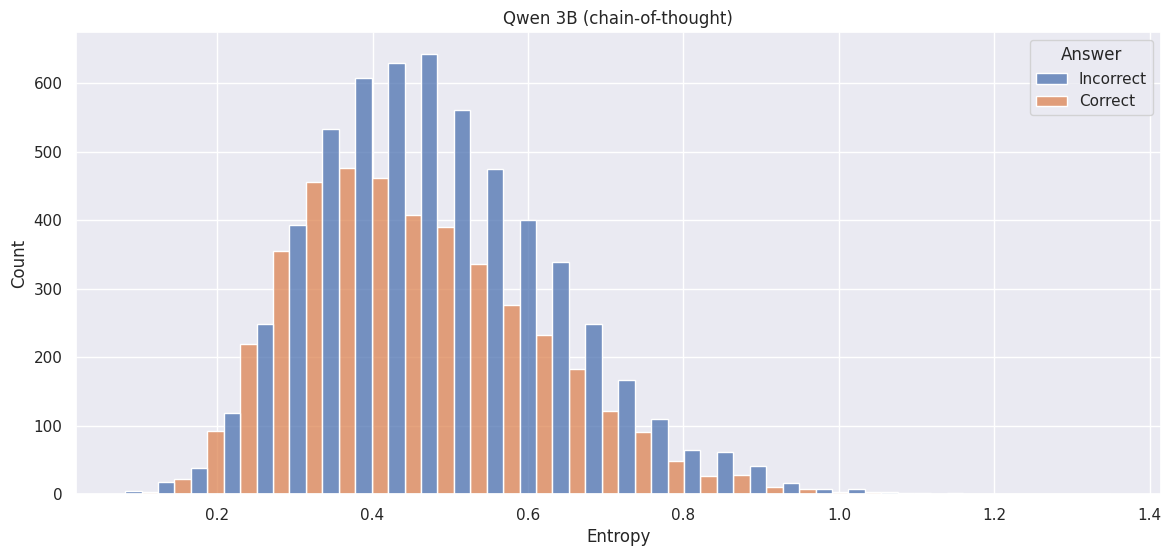

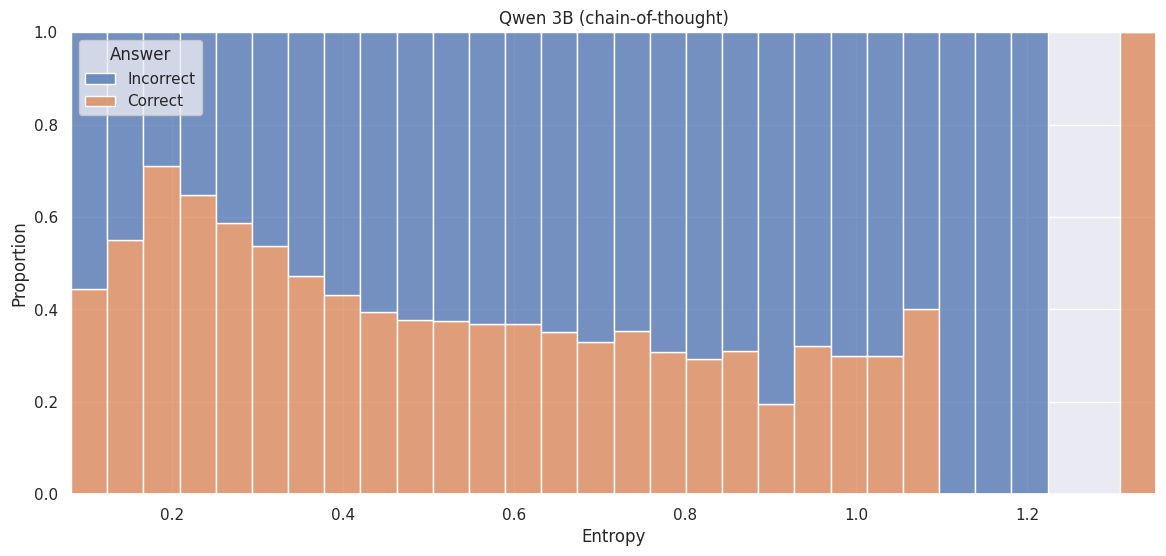

In [ ]:
splitters = [364, 558, 198, 279, 1402, 734, 1592, 3144, 502, 307, 26, 1008, 91587, 1612, 26289, 6658, 200020]
name = "phi3_answer_entropy_sequence_mean"


def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    # print()
    # answer_token_entropy = entropies[row[column_ans_token_index]]

    # top1, top2 = sorted(entropies, reverse=True)[:2]
    entr = []
    seq_entr = []
    counter = 0
    # print(row[args])
    for sublist in row[args]:
        # prob_max = np.argmax([item['token_prob'] for item in sublist])
        entr.append(entropies[counter])
        # print(entr)
        if sublist in splitters:
            # print(entr)
            seq_entr.append(np.mean(entr))
            # print(np.mean(entr))

            entr = []
        counter += 1
    return np.mean(seq_entr)


mmlu_entropy_df_filtered["phi3_answer_entropy_sequence_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_argmax_prob"), axis=1
)


visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Sequence mean max entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.591073,0.182146,9997,0.425828,Qwen-3b,phi3_answer_entropy_sequence_mean_max
1,law,0.554063,0.108127,990,0.259596,Qwen-3b,phi3_answer_entropy_sequence_mean_max
2,business,0.661645,0.323290,618,0.551780,Qwen-3b,phi3_answer_entropy_sequence_mean_max
3,psychology,0.554413,0.108826,769,0.481144,Qwen-3b,phi3_answer_entropy_sequence_mean_max
4,chemistry,0.581438,0.162875,852,0.431925,Qwen-3b,phi3_answer_entropy_sequence_mean_max
5,biology,0.538904,0.077808,679,0.480118,Qwen-3b,phi3_answer_entropy_sequence_mean_max
6,history,0.509088,0.018176,356,0.365169,Qwen-3b,phi3_answer_entropy_sequence_mean_max
7,other,0.590974,0.181947,842,0.416865,Qwen-3b,phi3_answer_entropy_sequence_mean_max
8,physics,0.542608,0.085216,990,0.385859,Qwen-3b,phi3_answer_entropy_sequence_mean_max
9,computer science,0.597642,0.195284,332,0.412651,Qwen-3b,phi3_answer_entropy_sequence_mean_max


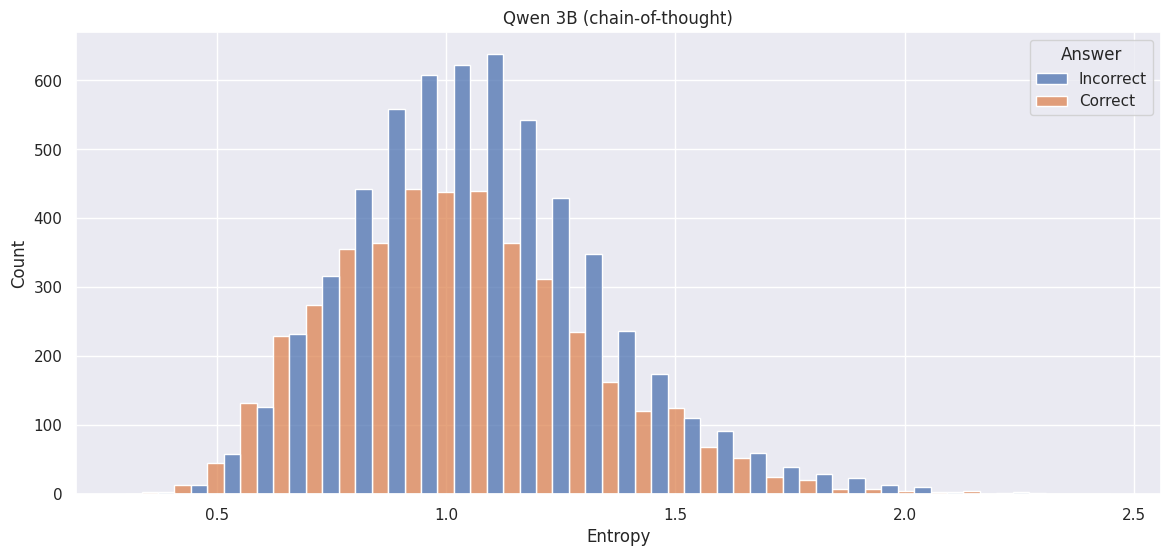

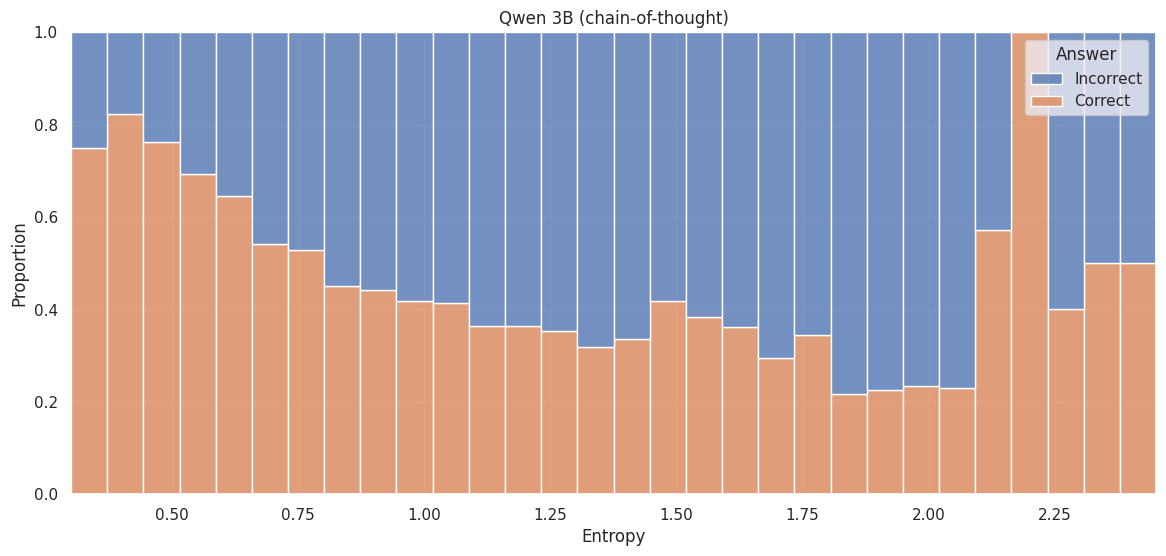

In [ ]:
def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    entr = []
    seq_entr = []
    counter = 0
    for sublist in row[args]:
        entr.append(entropies[counter])

        if sublist in splitters:
            seq_entr.append(np.mean(entr))

            entr = []
        counter += 1
    return np.max(seq_entr)


mmlu_entropy_df_filtered["phi3_answer_entropy_sequence_mean_max"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_argmax_prob"), axis=1
)

name = "phi3_answer_entropy_sequence_mean_max"

visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Sequence max mean entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.589581,0.179162,9997,0.425828,Qwen-3b,phi3_answer_entropy_sequence_max_mean
1,law,0.526821,0.053641,990,0.259596,Qwen-3b,phi3_answer_entropy_sequence_max_mean
2,business,0.666758,0.333517,618,0.551780,Qwen-3b,phi3_answer_entropy_sequence_max_mean
3,psychology,0.532101,0.064201,769,0.481144,Qwen-3b,phi3_answer_entropy_sequence_max_mean
4,chemistry,0.613721,0.227441,852,0.431925,Qwen-3b,phi3_answer_entropy_sequence_max_mean
5,biology,0.557752,0.115504,679,0.480118,Qwen-3b,phi3_answer_entropy_sequence_max_mean
6,history,0.525528,0.051055,356,0.365169,Qwen-3b,phi3_answer_entropy_sequence_max_mean
7,other,0.544891,0.089781,842,0.416865,Qwen-3b,phi3_answer_entropy_sequence_max_mean
8,physics,0.617629,0.235258,990,0.385859,Qwen-3b,phi3_answer_entropy_sequence_max_mean
9,computer science,0.572487,0.144975,332,0.412651,Qwen-3b,phi3_answer_entropy_sequence_max_mean


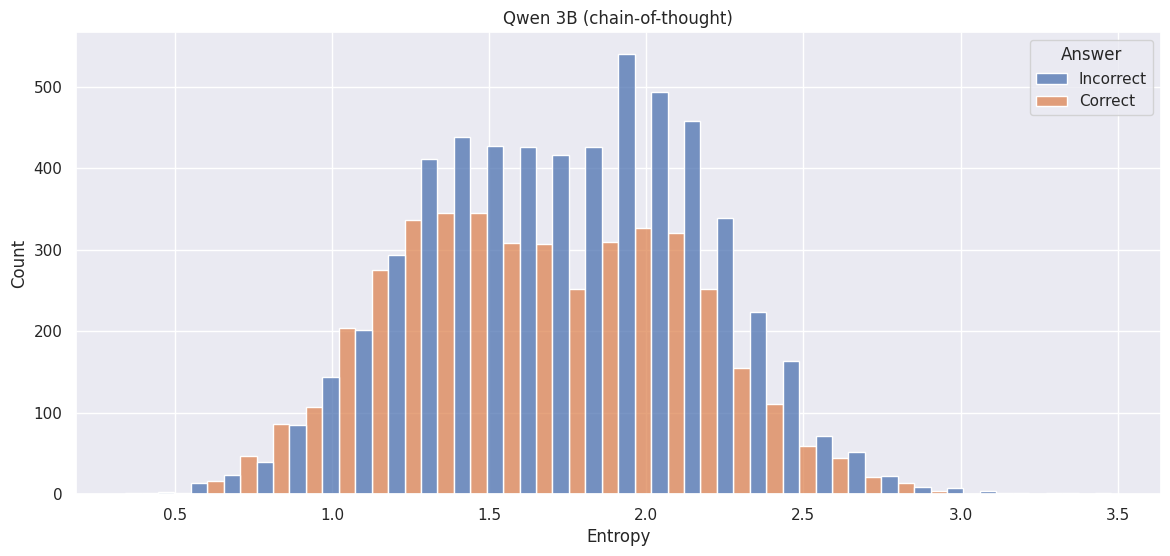

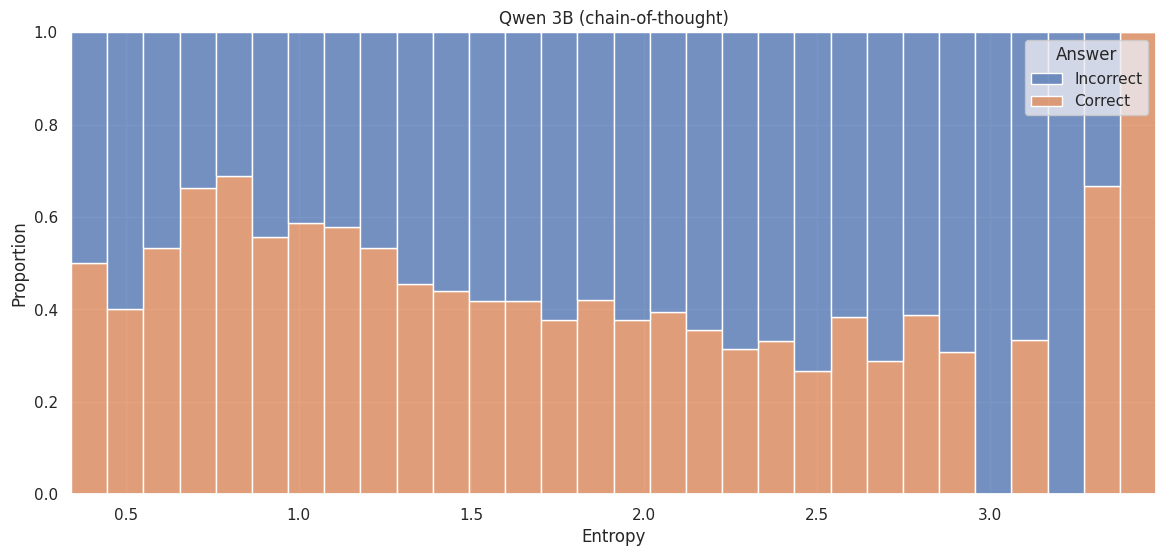

In [ ]:
def aver(row, column_entropies, args):
    entropies = json.loads(row[column_entropies])
    entr = []
    seq_entr = []
    counter = 0
    for sublist in row[args]:
        entr.append(entropies[counter])

        if sublist in splitters:
            seq_entr.append(np.max(entr))

            entr = []
        counter += 1
    return np.mean(seq_entr)


mmlu_entropy_df_filtered["phi3_answer_entropy_sequence_max_mean"] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_argmax_prob"), axis=1
)

name = "phi3_answer_entropy_sequence_max_mean"

visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


In [31]:
mmlu_entropy_df_filtered

,src,answer,options,category,question,cot_content,question_id,answer_index,total_tokens,meta_cluster,base_cluster,phi3_ans_correct,phi3_entropies,phi3_every_token_info,phi3_ans_token_index,phi3_response,phi3_input_embeddings,phi3_think_embeddings,phi3_answer_embeddings,phi3_answer,phi3_answer_entropy,phi3_prob_diff_ent,phi3_max_prob,phi3_argmax_prob,phi3_answer_entropy_cot_mean,phi3_answer_entropy_cot_max,phi3_answer_entropy_marg,phi3_answer_entropy_top_diff,phi3_answer_entropy_sequence_mean,phi3_answer_entropy_sequence_mean_max,phi3_answer_entropy_sequence_max_mean
0,ori_mmlu-jurisprudence,C,['There is no distinction between the two form...,law,Which of the following criticisms of Llewellyn...,NaN,1286,2,81,Legal Interpretation,Legal Theory Interpretations,True,"[0.8887168169021606, 1.6030447483062744, 0.143...","[[{""token_idx"": 12, ""token_prob"": 1.2961473657...",361,"To answer this question, let's first understan...","{""min"": [-1.7109375, -1.4453125, -0.97265625, ...","{""min"": [-1.7421875, -1.609375, -0.7421875, -1...","{""min"": [0.1708984375, -0.94921875, 0.34960937...",3,0.244582,0.284511,"[0.7760571241378784, 0.39040058851242065, 0.96...","[1385, 6052, 495, 4928, 11, 35717, 1577, 4218,...",0.768495,3.919251,3.674669,0.129001,0.620304,1.447478,1.908797
1,ori_mmlu-international_law,E,"['Article 19', 'Article 11', 'Article 12', 'Ar...",law,Which of the following articles are not qualif...,NaN,1293,4,38,Legal Interpretation,Constitutional Law,True,"[0.5754676461219788, 0.5695227384567261, 0.025...","[[{""token_idx"": 1, ""token_prob"": 1.48891549542...",319,To determine which of the given articles are n...,"{""min"": [-1.359375, -1.765625, -0.55859375, -1...","{""min"": [-2.0625, -1.6953125, -0.7421875, -1.3...","{""min"": [0.1123046875, -0.921875, 0.5234375, 1...",5,0.375497,0.261557,"[0.8914754390716553, 0.8471003174781799, 0.996...","[1385, 11433, 1118, 328, 290, 4335, 10604, 553...",0.696625,2.924063,2.548566,0.035894,0.765245,1.891376,2.206578
2,ori_mmlu-management,D,"['Work delegation', 'Workload balancing', 'Wor...",business,As what is ensuring that one individual does n...,NaN,83,3,49,Economics & Finance MCQs,Business & Marketing Queries,False,"[1.203656554222107, 1.445164442062378, 0.14232...","[[{""token_idx"": 1, ""token_prob"": 1.53181808855...",347,"To answer this question, let's analyze each op...","{""min"": [-1.5625, -1.828125, -0.53515625, -1.1...","{""min"": [-1.953125, -1.578125, -0.349609375, -...","{""min"": [0.130859375, -0.953125, 0.306640625, ...",2,0.483388,0.257388,"[0.7142872214317322, 0.4614185690879822, 0.969...","[1385, 6052, 495, 4928, 11, 35717, 30532, 2454...",0.644288,2.701768,2.218380,0.093472,0.607380,0.988072,2.035711
3,stemez-Business,J,"['$308.25', '$142.75', '$199.99', '$225.85', '...",business,Margaret Denault recently rented a truck to dr...,NaN,94,9,118,Economics & Finance MCQs,Business Finance Questions,False,"[0.6496801376342773, 1.174181342124939, 0.0581...","[[{""token_idx"": 16, ""token_prob"": 0.0012652330...",316,"To find the total cost of the rental, we need ...","{""min"": [-1.59375, -1.6015625, -0.36328125, -0...","{""min"": [-2.140625, -2.234375, -0.9921875, -2....","{""min"": [0.08251953125, -0.859375, 0.36328125,...",1,1.903746,0.199315,"[0.8415591716766357, 0.5737806558609009, 0.990...","[1385, 1646, 290, 3609, 3097, 328, 290, 15991,...",0.492199,2.611734,0.707988,0.092270,0.374459,0.874300,1.198651
4,stemez-Business,I,"['$60,000', '$43,200', '$1,794', '$25,000', '$...",business,The tax rate in the town of Centerville is 11(...,NaN,104,8,102,Economics & Finance MCQs,Business Finance Questions,True,"[0.9100953340530396, 1.2733248472213745, 0.026...","[[{""token_idx"": 16, ""token_prob"": 0.0039558755...",154,To find the expected market value of the prope...,"{""min"": [-1.5, -1.4453125, -0.578125, -0.85156...","{""min"": [-2.0625, -2.125, -0.8203125, -1.125, ...","{""min"": [0.06640625, -1.015625, 0.44140625, 1....",9,0.536843,0.141850,"[0.7538564205169678, 0.39

<h2>Entropy of Answer<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.610654,0.221308,9997,0.425828,Qwen-3b,phi3_answer_entropy
1,law,0.554578,0.109156,990,0.259596,Qwen-3b,phi3_answer_entropy
2,business,0.661105,0.322210,618,0.551780,Qwen-3b,phi3_answer_entropy
3,psychology,0.677322,0.354643,769,0.481144,Qwen-3b,phi3_answer_entropy
4,chemistry,0.652792,0.305583,852,0.431925,Qwen-3b,phi3_answer_entropy
5,biology,0.645067,0.290134,679,0.480118,Qwen-3b,phi3_answer_entropy
6,history,0.590402,0.180803,356,0.365169,Qwen-3b,phi3_answer_entropy
7,other,0.597461,0.194922,842,0.416865,Qwen-3b,phi3_answer_entropy
8,physics,0.623368,0.246736,990,0.385859,Qwen-3b,phi3_answer_entropy
9,computer science,0.588845,0.177690,332,0.412651,Qwen-3b,phi3_answer_entropy


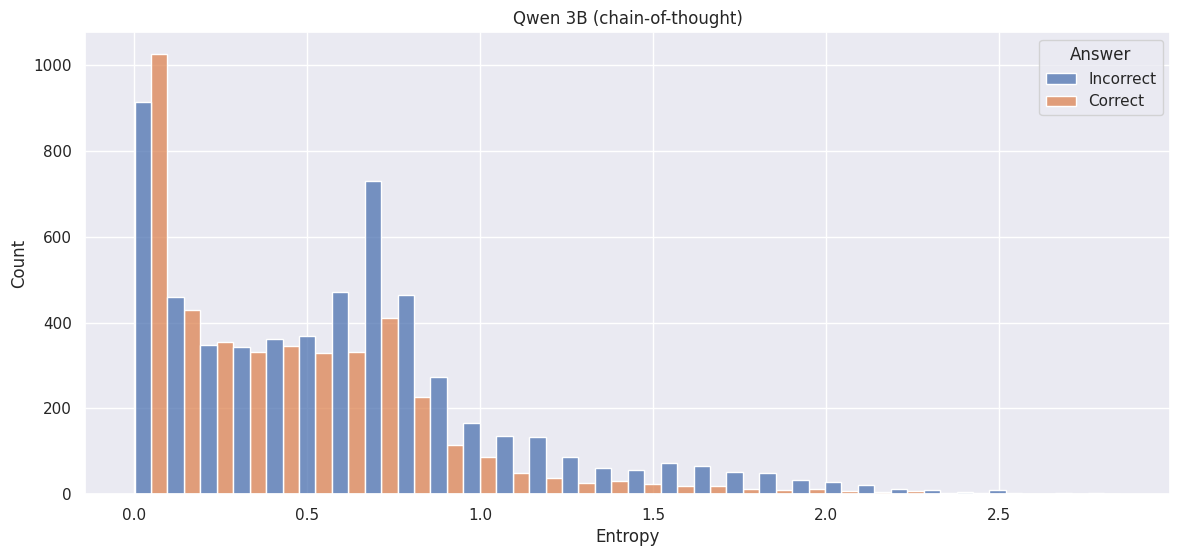

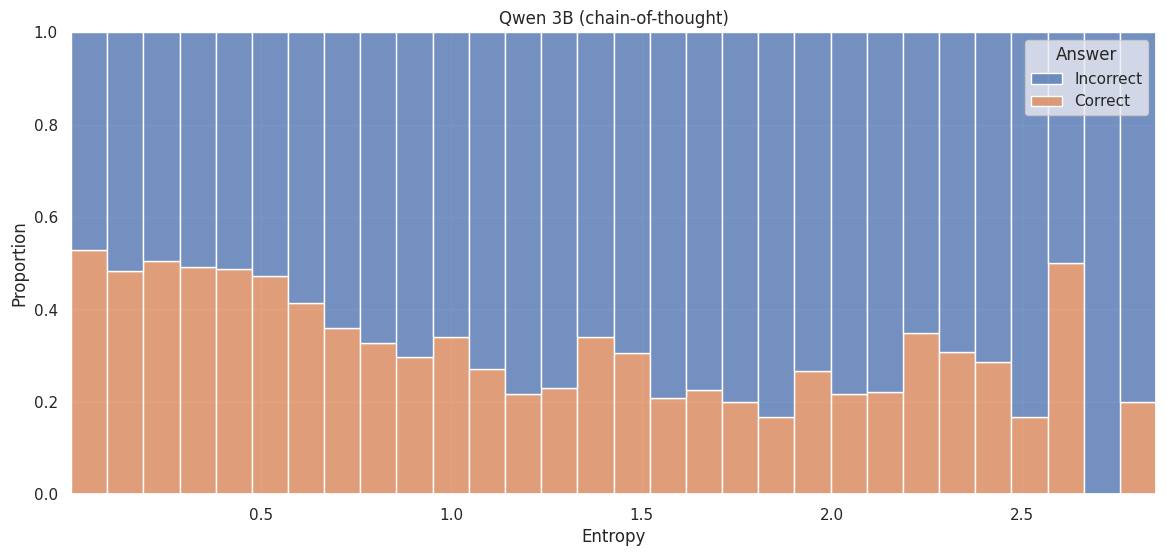

In [32]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_answer_entropy", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)

# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy",
    model_name=model_title,
)
roc_auc_res

<h2>COT max entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.599935,0.199869,9997,0.425828,Qwen-3b,phi3_answer_entropy_cot_max
1,law,0.490628,0.018744,990,0.259596,Qwen-3b,phi3_answer_entropy_cot_max
2,business,0.681347,0.362694,618,0.551780,Qwen-3b,phi3_answer_entropy_cot_max
3,psychology,0.557495,0.114990,769,0.481144,Qwen-3b,phi3_answer_entropy_cot_max
4,chemistry,0.603542,0.207083,852,0.431925,Qwen-3b,phi3_answer_entropy_cot_max
5,biology,0.552477,0.104955,679,0.480118,Qwen-3b,phi3_answer_entropy_cot_max
6,history,0.528727,0.057454,356,0.365169,Qwen-3b,phi3_answer_entropy_cot_max
7,other,0.554575,0.109150,842,0.416865,Qwen-3b,phi3_answer_entropy_cot_max
8,physics,0.573100,0.146201,990,0.385859,Qwen-3b,phi3_answer_entropy_cot_max
9,computer science,0.609508,0.219016,332,0.412651,Qwen-3b,phi3_answer_entropy_cot_max


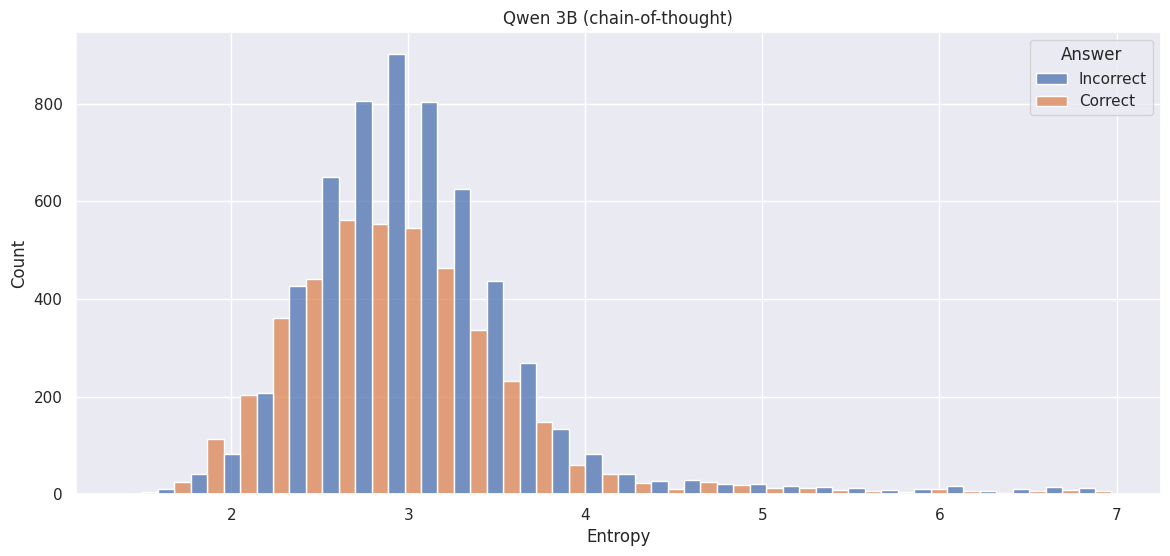

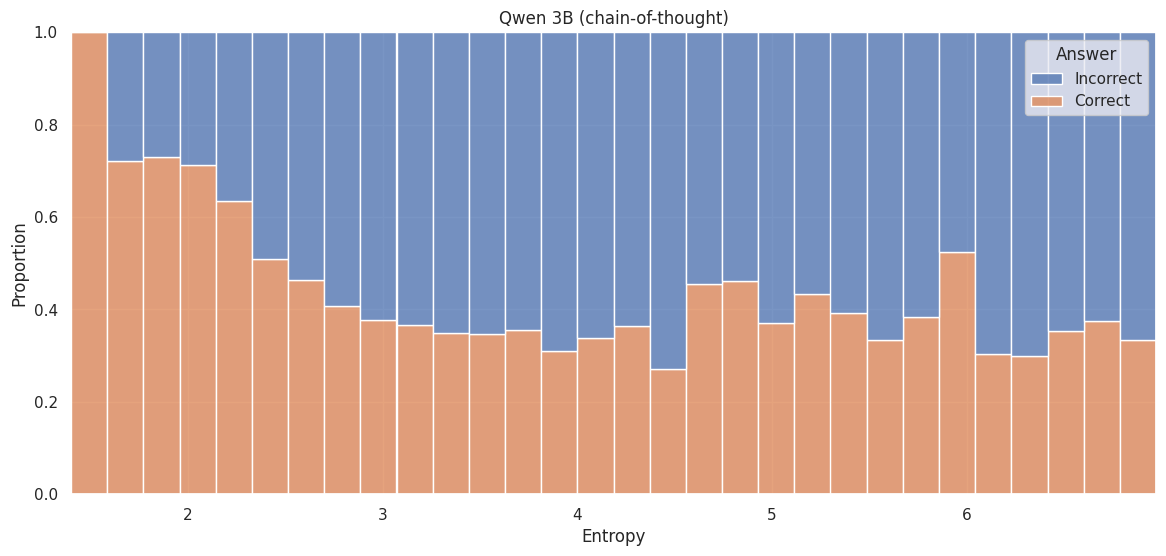

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_answer_entropy_cot_max", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_cot_max",
    model_name=model_title,
)
roc_auc_res


<h2>COT mean entropy<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.593563,0.187126,9997,0.425828,Qwen-3b,phi3_answer_entropy_cot_mean
1,law,0.484561,0.030879,990,0.259596,Qwen-3b,phi3_answer_entropy_cot_mean
2,business,0.689880,0.379760,618,0.551780,Qwen-3b,phi3_answer_entropy_cot_mean
3,psychology,0.551737,0.103475,769,0.481144,Qwen-3b,phi3_answer_entropy_cot_mean
4,chemistry,0.630766,0.261532,852,0.431925,Qwen-3b,phi3_answer_entropy_cot_mean
5,biology,0.538426,0.076852,679,0.480118,Qwen-3b,phi3_answer_entropy_cot_mean
6,history,0.508305,0.016610,356,0.365169,Qwen-3b,phi3_answer_entropy_cot_mean
7,other,0.543579,0.087159,842,0.416865,Qwen-3b,phi3_answer_entropy_cot_mean
8,physics,0.642274,0.284548,990,0.385859,Qwen-3b,phi3_answer_entropy_cot_mean
9,computer science,0.566536,0.133071,332,0.412651,Qwen-3b,phi3_answer_entropy_cot_mean


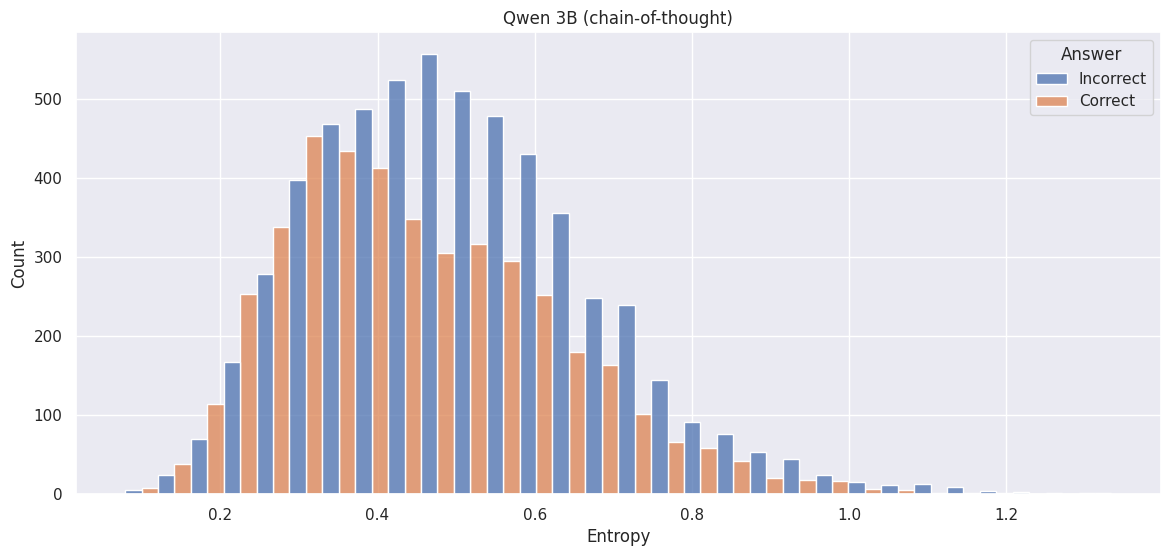

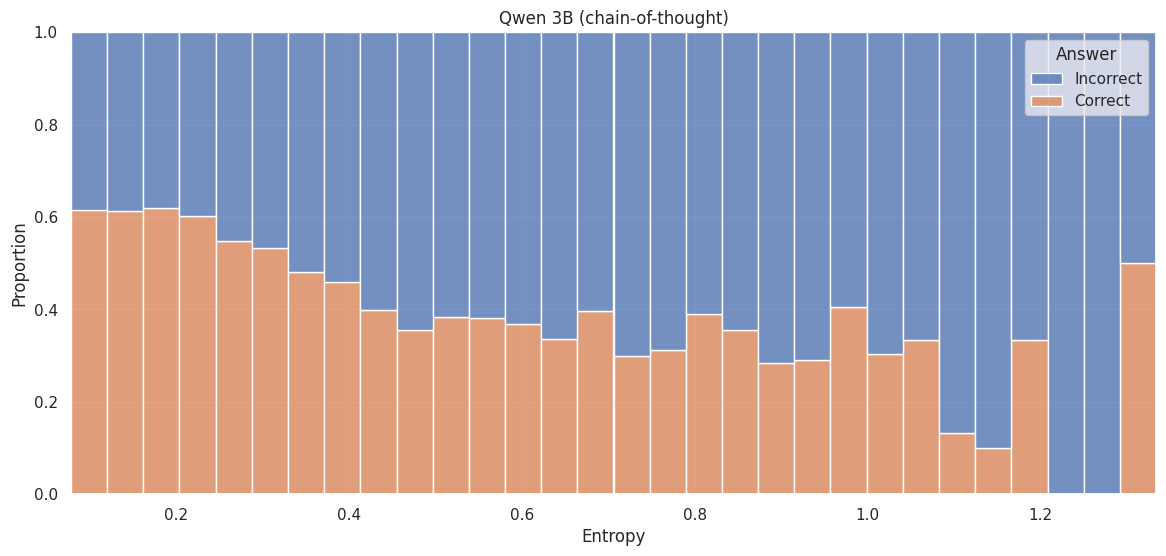

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "phi3_answer_entropy_cot_mean",
    "phi3_ans_correct",
    model_name="Qwen 3B (chain-of-thought)",
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_cot_mean",
    model_name=model_title,
)
roc_auc_res


<h2>Max COT entropy and answer entropy difference<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.514101,0.028203,9997,0.425828,Qwen-3b,phi3_answer_entropy_marg
1,law,0.452869,0.094261,990,0.259596,Qwen-3b,phi3_answer_entropy_marg
2,business,0.544163,0.088326,618,0.551780,Qwen-3b,phi3_answer_entropy_marg
3,psychology,0.426878,0.146244,769,0.481144,Qwen-3b,phi3_answer_entropy_marg
4,chemistry,0.488648,0.022705,852,0.431925,Qwen-3b,phi3_answer_entropy_marg
5,biology,0.449417,0.101166,679,0.480118,Qwen-3b,phi3_answer_entropy_marg
6,history,0.468414,0.063172,356,0.365169,Qwen-3b,phi3_answer_entropy_marg
7,other,0.483907,0.032186,842,0.416865,Qwen-3b,phi3_answer_entropy_marg
8,physics,0.482812,0.034376,990,0.385859,Qwen-3b,phi3_answer_entropy_marg
9,computer science,0.522740,0.045480,332,0.412651,Qwen-3b,phi3_answer_entropy_marg


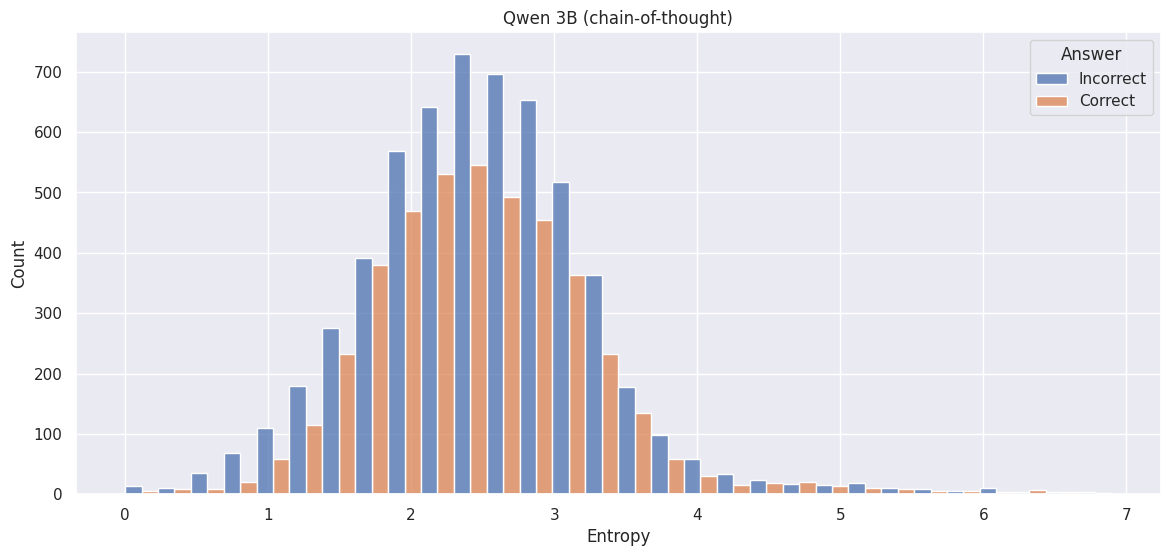

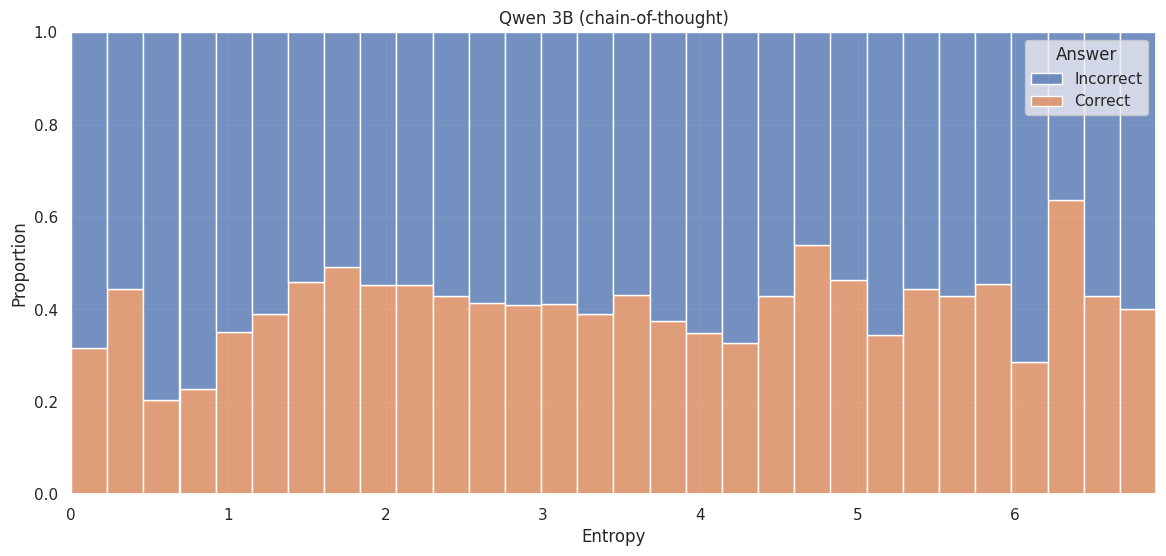

In [ ]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_answer_entropy_marg", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_marg",
    model_name=model_title,
)
roc_auc_res

<h2>Mean of Marginal difference of 2 highest probs for each token<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.579659,0.159318,9997,0.425828,Qwen-3b,phi3_prob_diff_ent
1,law,0.475080,0.049840,990,0.259596,Qwen-3b,phi3_prob_diff_ent
2,business,0.661656,0.323311,618,0.551780,Qwen-3b,phi3_prob_diff_ent
3,psychology,0.538895,0.077789,769,0.481144,Qwen-3b,phi3_prob_diff_ent
4,chemistry,0.613636,0.227273,852,0.431925,Qwen-3b,phi3_prob_diff_ent
5,biology,0.538556,0.077113,679,0.480118,Qwen-3b,phi3_prob_diff_ent
6,history,0.499592,0.000817,356,0.365169,Qwen-3b,phi3_prob_diff_ent
7,other,0.533303,0.066606,842,0.416865,Qwen-3b,phi3_prob_diff_ent
8,physics,0.630378,0.260755,990,0.385859,Qwen-3b,phi3_prob_diff_ent
9,computer science,0.545836,0.091671,332,0.412651,Qwen-3b,phi3_prob_diff_ent


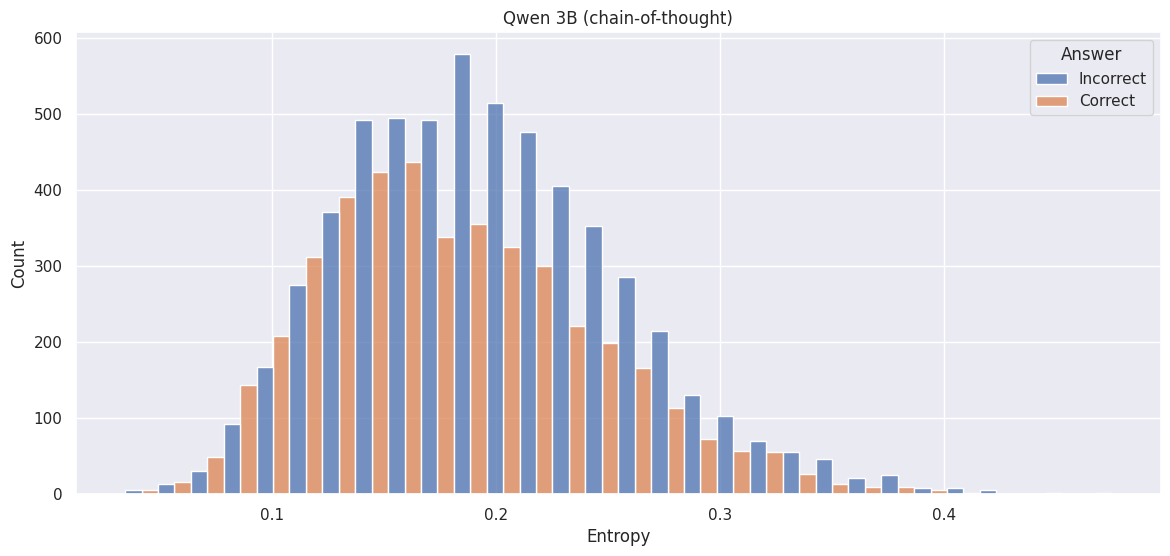

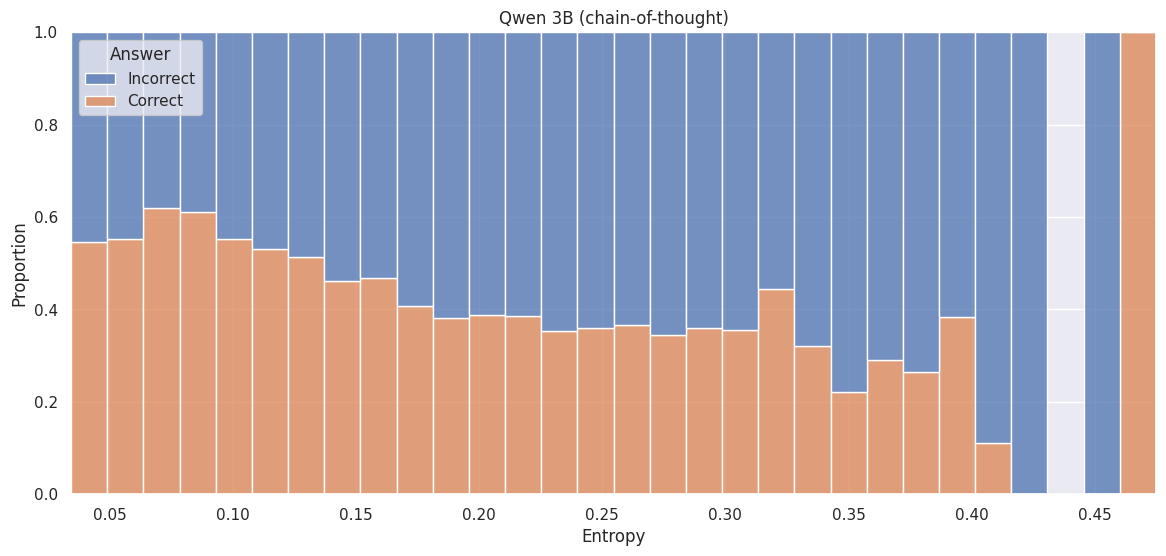

In [36]:
# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(
    mmlu_entropy_df_filtered, "phi3_prob_diff_ent", "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)"
)


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_prob_diff_ent",
    model_name=model_title,
)
roc_auc_res


<h2>Answer Entropy and Max COT mixed<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.618437,0.236873,9997,0.425828,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
1,law,0.550953,0.101905,990,0.259596,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
2,business,0.672814,0.345628,618,0.551780,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
3,psychology,0.682016,0.364032,769,0.481144,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
4,chemistry,0.655206,0.310411,852,0.431925,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
5,biology,0.647448,0.294896,679,0.480118,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
6,history,0.591014,0.182029,356,0.365169,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
7,other,0.600252,0.200504,842,0.416865,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
8,physics,0.626020,0.252041,990,0.385859,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix
9,computer science,0.599401,0.198802,332,0.412651,Qwen-3b,phi3_answer_entropy_max_ans_entropy_mix


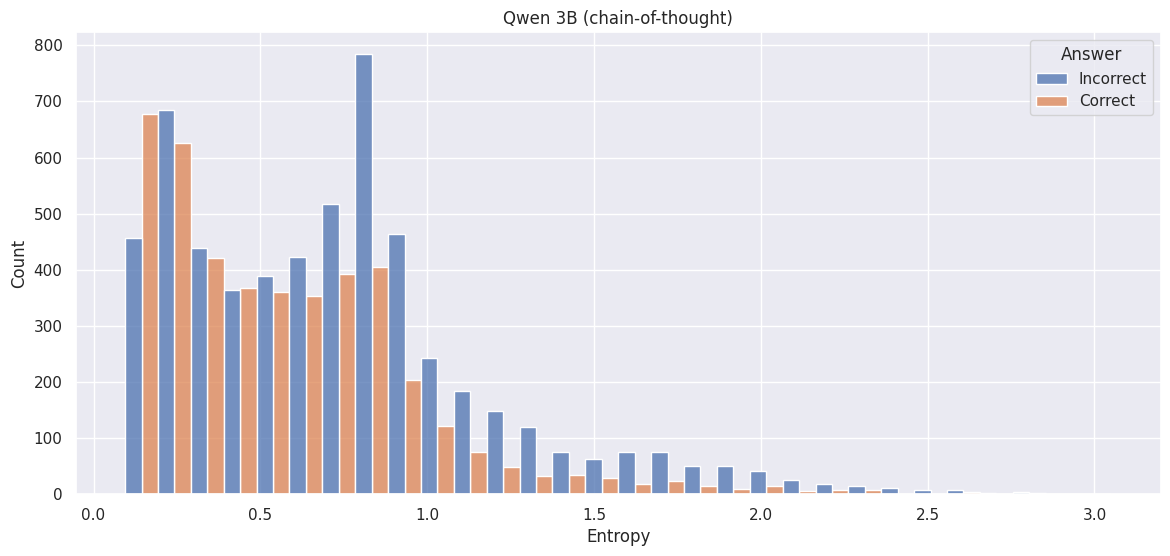

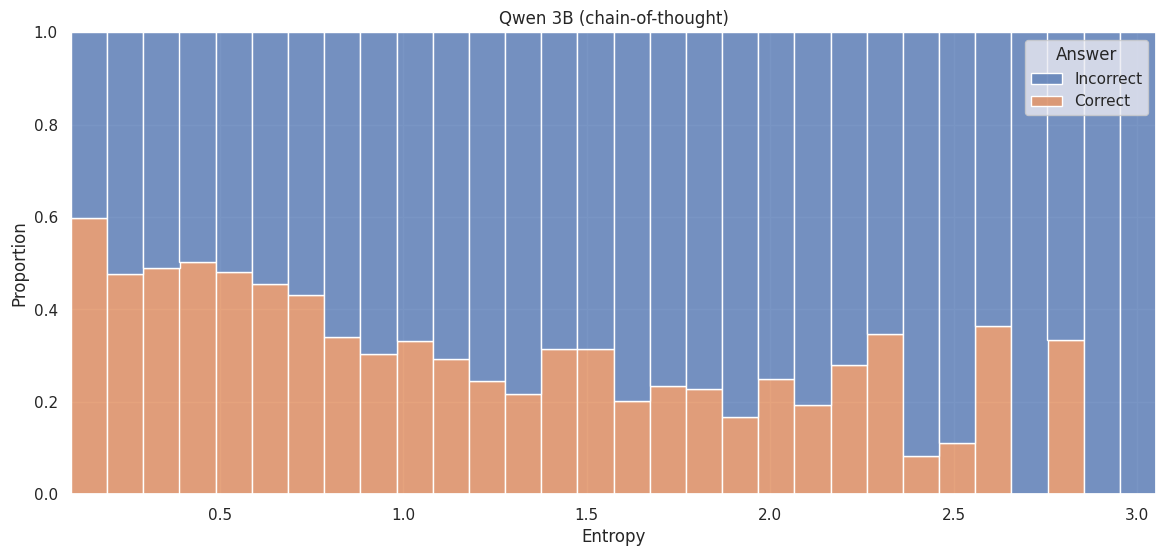

In [ ]:
name = "phi3_answer_entropy_max_ans_entropy_mix"


def aver(row, column_entropies, column_ans_token_index):
    entropies = json.loads(row[column_entropies])
    answer_token_entropy = entropies[row[column_ans_token_index]]
    return 0.05 * np.max([ind for ind in entropies]) + 0.95 * answer_token_entropy


mmlu_entropy_df_filtered[name] = mmlu_entropy_df_filtered.apply(
    lambda row: aver(row, "phi3_entropies", "phi3_ans_token_index"), axis=1
)

# from reasoning_fine_tune.analysis.visualize_entropy_all import visualize_entropy_all

visualize_entropy_all(mmlu_entropy_df_filtered, name, "phi3_ans_correct", model_name="Qwen 3B (chain-of-thought)")


# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"


roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col=name,
    model_name=model_title,
)
roc_auc_res


<h2>Diff of 2 highest entropies<h2>

,category,roc_auc,gini,num_samples,accuracy,model,metric
0,ALL,0.495919,0.008163,9997,0.425828,Qwen-3b,phi3_answer_entropy_top_diff
1,law,0.456819,0.086362,990,0.259596,Qwen-3b,phi3_answer_entropy_top_diff
2,business,0.486454,0.027092,618,0.551780,Qwen-3b,phi3_answer_entropy_top_diff
3,psychology,0.497277,0.005446,769,0.481144,Qwen-3b,phi3_answer_entropy_top_diff
4,chemistry,0.497193,0.005614,852,0.431925,Qwen-3b,phi3_answer_entropy_top_diff
5,biology,0.508638,0.017275,679,0.480118,Qwen-3b,phi3_answer_entropy_top_diff
6,history,0.499523,0.000953,356,0.365169,Qwen-3b,phi3_answer_entropy_top_diff
7,other,0.475998,0.048004,842,0.416865,Qwen-3b,phi3_answer_entropy_top_diff
8,physics,0.471553,0.056894,990,0.385859,Qwen-3b,phi3_answer_entropy_top_diff
9,computer science,0.504735,0.009470,332,0.412651,Qwen-3b,phi3_answer_entropy_top_diff


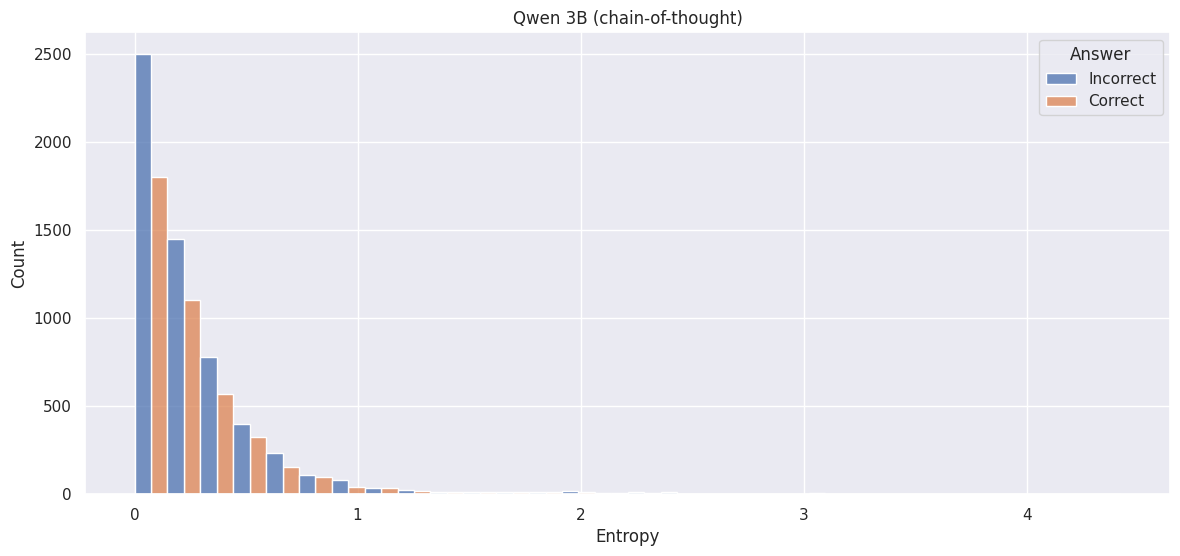

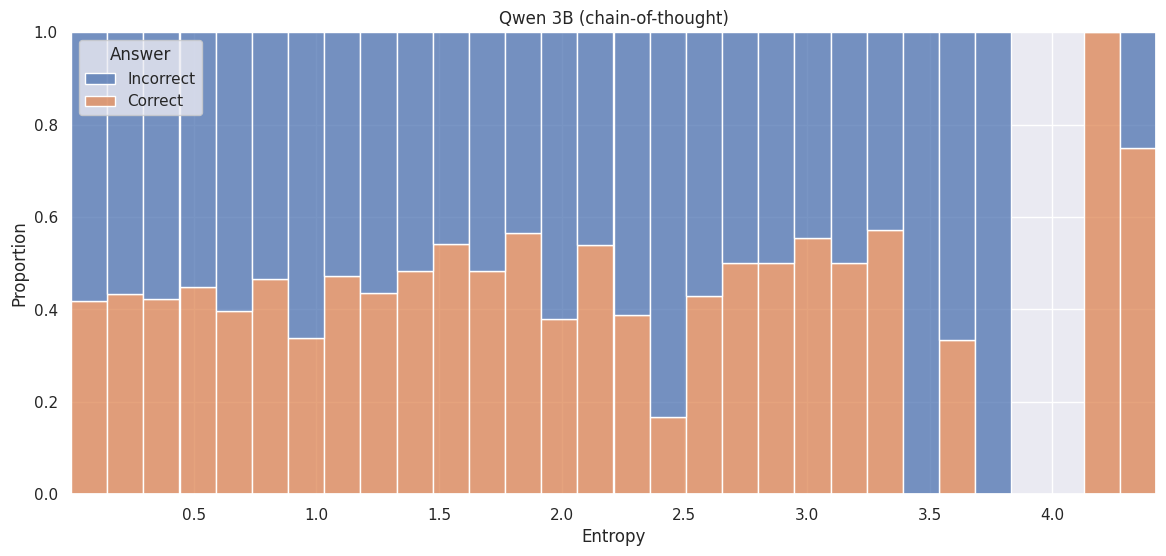

In [ ]:
# from reasoning_fine_tune.analysis.roc_auc import calculate_roc_auc_by_category
model_title = "Qwen-3b"

visualize_entropy_all(
    mmlu_entropy_df_filtered,
    "phi3_answer_entropy_top_diff",
    "phi3_ans_correct",
    model_name="Qwen 3B (chain-of-thought)",
)

roc_auc_res = calculate_roc_auc_by_category(
    mmlu_entropy_df_filtered,
    category_col="category",
    model_answer_correct_col="phi3_ans_correct",
    score_col="phi3_answer_entropy_top_diff",
    model_name=model_title,
)
roc_auc_res
